In [22]:
import numpy as np 
import pandas as pd 
from subprocess import check_output
#print(check_output(["ls", "../icaMark/plots"]).decode("utf8"))

In [23]:
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep

Working with 3840 images
Image examples: 
subj10_series10_19.png


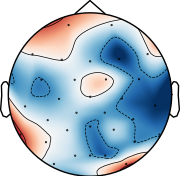

subj10_series10_2.png


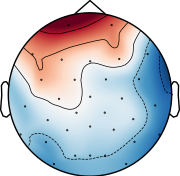

In [24]:
folder = "../icaMark/plots"

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

for i in range(10, 12):
    print(onlyfiles[i])
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=180, height=176))

In [25]:
image_labels = pd.read_csv("../icaMark/all_labels_short.csv", header=None, 
                            names=['filename','class'], dtype={'filename':object,'class':np.int64})
image_labels.head()

,filename,class
0,subj10_series10_1.png,1
1,subj10_series10_2.png,0
2,subj10_series10_3.png,1
3,subj10_series10_4.png,1
4,subj10_series10_5.png,1


In [26]:
from scipy import ndimage
import keras
from keras.preprocessing.image import img_to_array, load_img

train_files = []
y_train = []
for _file in onlyfiles:
    train_files.append(_file) 
    y_train.append( image_labels[image_labels.filename == _file]["class"].iloc[0] )
print("Files in train_files: %d" % len(train_files))

# Original Dimensions
image_width = 180
image_height = 176

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)

i = 0
for _file in train_files:
    img = load_img(folder + "/" + _file) 
    img.thumbnail((image_width, image_height))
    x = img_to_array(img)  
    x = (x - 128.0) / 128.0
    dataset[i] = x
    i += 1
    if i % 250 == 0:
        print("%d images to array" % i)
print("All images to array!")


Files in train_files: 3840
250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
All images to array!


In [27]:
dataset.shape, len(y_train)

((3840, 176, 180, 3), 3840)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    dataset,
    y_train,
    test_size=0.2,
    random_state=33,
    shuffle=True,
    stratify=y_train
)
print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 3072, Test set size: 768


In [29]:
y_train
np.asarray(y_train)
len(X_train)
X_train.shape
#import np_utils.to_categorical as to_categorical

(3072, 176, 180, 3)

In [30]:
y_train = np.asarray(y_train).reshape(len(X_train),1)
y_test = np.asarray(y_test).reshape(len(X_test),1)

In [31]:
y_train.shape, X_train.shape
len(X_train)

3072

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import time
NB_CHANNELS = 3
BATCH_SIZE = 16 # Typical values are 8, 16 or 32
NB_TRAIN_IMG = len(X_train)
NB_VALID_IMG = len(X_test) 

In [54]:
from keras import backend as K
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

In [55]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, 
               kernel_size=(2,2), 
               strides=(1,1),
               padding='same',
               input_shape=(176,180,NB_CHANNELS),
               data_format='channels_last'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
               strides=2))
cnn.add(Conv2D(filters=64,
               kernel_size=(2,2),
               strides=(1,1),
               padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Flatten())        
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(units=1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[recall, precision, f1])

In [ ]:
start = time.time()
cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=BATCH_SIZE)
end = time.time()
print('Processing time:',(end - start)/60)

Train on 3072 samples, validate on 768 samples
Epoch 1/10
3072/3072 [==============================] - 45s 15ms/step - loss: 0.2986 - recall: 0.9893 - precision: 0.9378 - f1: 0.9616 - val_loss: 0.1987 - val_recall: 1.0000 - val_precision: 0.9339 - val_f1: 0.9647
Epoch 2/10
3072/3072 [==============================] - 49s 16ms/step - loss: 0.2129 - recall: 0.9894 - precision: 0.9464 - f1: 0.9663 - val_loss: 0.1603 - val_recall: 0.9986 - val_precision: 0.9467 - val_f1: 0.9709
Epoch 3/10
3072/3072 [==============================] - 47s 15ms/step - loss: 0.1963 - recall: 0.9908 - precision: 0.9531 - f1: 0.9705 - val_loss: 0.1585 - val_recall: 0.9986 - val_precision: 0.9506 - val_f1: 0.9730
Epoch 4/10
2576/3072 [========================>.....] - ETA: 7s - loss: 0.1885 - recall: 0.9904 - precision: 0.9557 - f1: 0.9719

In [ ]:
cnn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

cnn.save_weights('cnn_weights.h5')
from keras.models import model_from_json
model_json = cnn.to_json()
with open("cnn_struct.json", "w") as json_file:
    json_file.write(model_json) 

In [36]:
( np.sum(y_train)+np.sum(y_test) ) / ( len(y_train)+len(y_test) )

0.9130208333333333